# Predictions statistics

Let's analyse the predictions made on our test datasplit.

**Note** To run this notebook you previously have to run and save the predictions on a test dataset **with ground-truth labels**. See the Datasplit section in [3.0 notebook](./3.0-Computing_predictions.ipynb#Predicting-a-datasplit-txt-file) for reference.


In [1]:
import tensorflow as tf
print(tf.__version__)

1.14.0


In [11]:
import os
import json
import numpy as np

from imgclas.data_utils import load_image, load_class_names
from imgclas import paths, plot_utils

import warnings
warnings.filterwarnings("ignore") # To ignore UndefinedMetricWarning: [Recall/Precision/F-Score] is ill-defined and being set to 0.0 in labels with no [true/predicted] samples.

# User parameters to set
TIMESTAMP = '2022-04-20_Fold5SpAnd45Balanced_21ep_stop15_16Batch'      # timestamp of the model
SPLIT_NAME = 'test'                   # dataset split to predict
MODEL_NAME = 'final_model.h5'         # model to use to make the mediction
TOP_K = 2                             # number of top classes predictions to save

# Set the timestamp
paths.timestamp = TIMESTAMP

# Load clas names
class_names = load_class_names(splits_dir=paths.get_ts_splits_dir())

# Load back the predictions
pred_path = os.path.join(paths.get_predictions_dir(), '{}+{}+top{}.json'.format(MODEL_NAME, SPLIT_NAME, TOP_K))
with open(pred_path) as f:
    pred_dict = json.load(f)

Loading class names...


## Computing the metrics

Check [sklearn](https://scikit-learn.org/stable/modules/classes.html#classification-metrics) for more classification metrics.

In [12]:
from imgclas import test_utils
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


true_lab, pred_lab = np.array(pred_dict['true_lab']), np.array(pred_dict['pred_lab'])

top1 = test_utils.topK_accuracy(true_lab, pred_lab, K=1)
# top5 = test_utils.topK_accuracy(true_lab, pred_lab, K=5)

print('Top1 accuracy: {:.1f} %'.format(top1 * 100))
# print('Top5 accuracy: {:.1f} %'.format(top5 * 100))

labels = range(len(class_names))
print('\n')
print('Micro recall: {:.1f} %'.format(100 * recall_score(true_lab, pred_lab[:, 0], labels=labels, average='micro')))
print('Macro recall: {:.1f} %'.format(100 * recall_score(true_lab, pred_lab[:, 0], labels=labels, average='macro')))
print('Macro recall (no labels): {:.1f} %'.format(100 * recall_score(true_lab, pred_lab[:, 0], average='macro')))
print('Weighted recall: {:.1f} %'.format(100 * recall_score(true_lab, pred_lab[:, 0], labels=labels, average='weighted')))

print('\n')
print('Micro precision: {:.1f} %'.format(100 * precision_score(true_lab, pred_lab[:, 0], labels=labels, average='micro')))
print('Macro precision: {:.1f} %'.format(100 * precision_score(true_lab, pred_lab[:, 0], labels=labels, average='macro')))
print('Macro precision (no labels): {:.1f} %'.format(100 * precision_score(true_lab, pred_lab[:, 0], average='macro')))
print('Weighted precision: {:.1f} %'.format(100 * precision_score(true_lab, pred_lab[:, 0], labels=labels, average='weighted')))

print('\n')
print('Micro F1 score: {:.1f} %'.format(100 * f1_score(true_lab, pred_lab[:, 0], labels=labels, average='micro')))
print('Macro F1 score: {:.1f} %'.format(100 * f1_score(true_lab, pred_lab[:, 0], labels=labels, average='macro')))
print('Macro F1 score (no labels): {:.1f} %'.format(100 * f1_score(true_lab, pred_lab[:, 0], average='macro')))
print('Weighted F1 score: {:.1f} %'.format(100 * f1_score(true_lab, pred_lab[:, 0], labels=labels, average='weighted')))

Top1 accuracy: 85.4 %


Micro recall: 85.4 %
Macro recall: 85.4 %
Macro recall (no labels): 85.4 %
Weighted recall: 85.4 %


Micro precision: 85.4 %
Macro precision: 88.7 %
Macro precision (no labels): 88.7 %
Weighted precision: 88.7 %


Micro F1 score: 85.4 %
Macro F1 score: 85.1 %
Macro F1 score (no labels): 85.1 %
Weighted F1 score: 85.1 %


In [13]:
scores=[]
for i in range(0, len(pred_dict['pred_lab'])):
    if pred_dict['pred_lab'][i][0]==0:
        scores.append(pred_dict['pred_prob'][i][1])
    else:
        scores.append(pred_dict['pred_prob'][i][0])

In [14]:
# https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
# computing sensibility, specificity and ROC curve.
# calculate roc curve
probs = np.array([item[0] for item in pred_dict['pred_prob']])
y_pred = np.array([item[0] for item in pred_lab])
# calculate AUC
auc = roc_auc_score(true_lab, y_pred) # este seria sin tener en cuenta las probabilidades!
auc = roc_auc_score(true_lab, scores)
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_pred, probs)
# calculate F1 score
f1 = f1_score(true_lab, y_pred, average='weighted')
# calculate precision
precision = precision_score(true_lab, y_pred, average='weighted')
# calculate recall
recall = recall_score(true_lab, y_pred, average='weighted')
# standard confussion matrix
TN, FP, FN, TP = confusion_matrix(true_lab, y_pred, labels=[0, 1]).ravel()
sensitivity  = TP/(TP+FN)
specificity  = TN/(TN+FP)
pos_pred_val = TP/(TP+FP)
neg_pred_val = TN/(TN+FN)
print('Sensitivity: %.2f' % sensitivity)
print('Specificity: %.2f' % specificity)
print('Precision: %.2f' % precision)
print('Recall: %.2f' % recall)
print('F1 score: %.2f' % f1)
print('AUC: %.2f' % auc)

Sensitivity: 1.00
Specificity: 0.71
Precision: 0.89
Recall: 0.85
F1 score: 0.85
AUC: 0.99


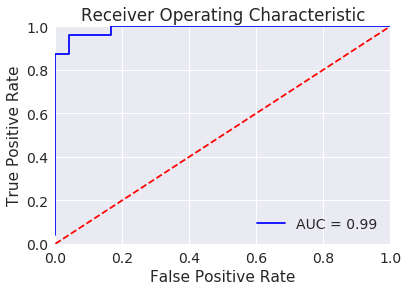

In [15]:
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
fpr, tpr, thresholds = roc_curve(true_lab, scores)
roc_auc = metrics.auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Computing the confusion matrix

In [16]:
import matplotlib.pylab as plt
import seaborn
from sklearn.metrics import confusion_matrix


def plt_conf_matrix(conf_mat,  name, labels=False):
    
    fig = plt.figure(figsize=(20, 20))
    seaborn.set(font_scale=1.4)
    hm = seaborn.heatmap(conf_mat, annot=True, square=True, cbar_kws={'fraction':0.046, 'pad':0.04},
                         xticklabels=labels, yticklabels=labels, cmap=plt.cm.Blues, fmt=".2f")
    fontsize = None
    hm.yaxis.set_ticklabels(hm.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    hm.xaxis.set_ticklabels(hm.xaxis.get_ticklabels(), rotation=90, ha='right', fontsize=fontsize)

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
#     plt.savefig('/srv/image-results/'+name+'_confussionMatrix.jpg')

### Standard confusion matrix

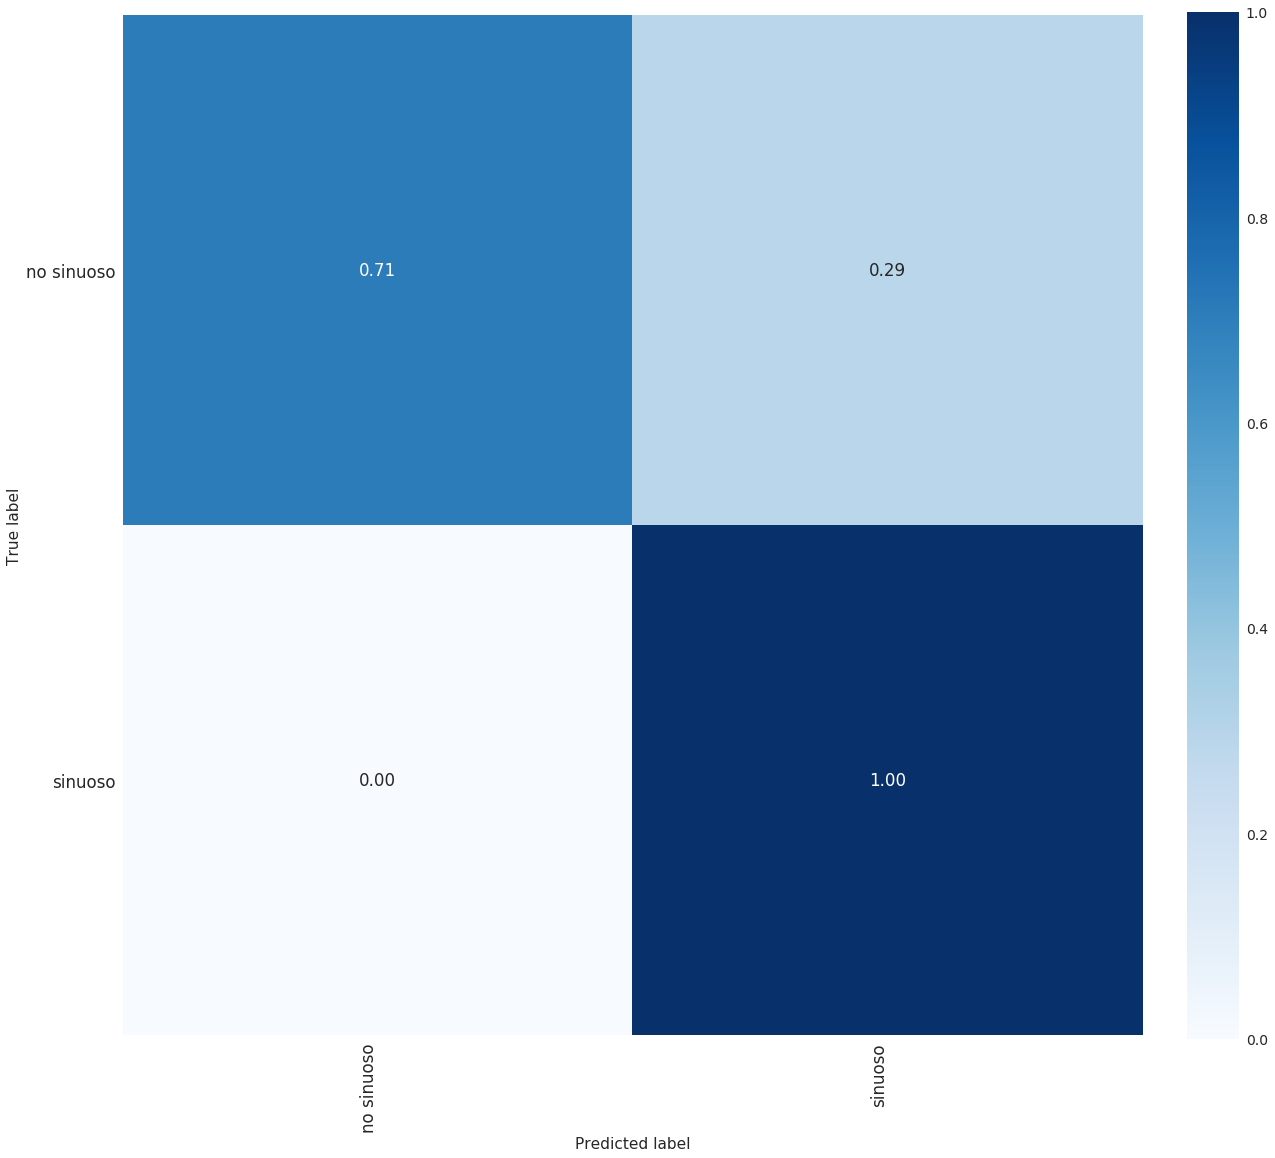

In [17]:
y_true, y_pred = np.array(pred_dict['true_lab']), np.array(pred_dict['pred_lab'])[:, 0]
conf_mat = confusion_matrix(y_true, y_pred, labels=range(len(class_names)), sample_weight=None)
normed_conf = conf_mat / np.sum(conf_mat, axis=1)[:, np.newaxis]

# plt_conf_matrix(conf_mat)
plt_conf_matrix(normed_conf, labels=class_names, name='Predicciones_Sinusoidad')

### Weighted confusion matrix
We weight each count in the confusion matrix by the probability of the prediction.

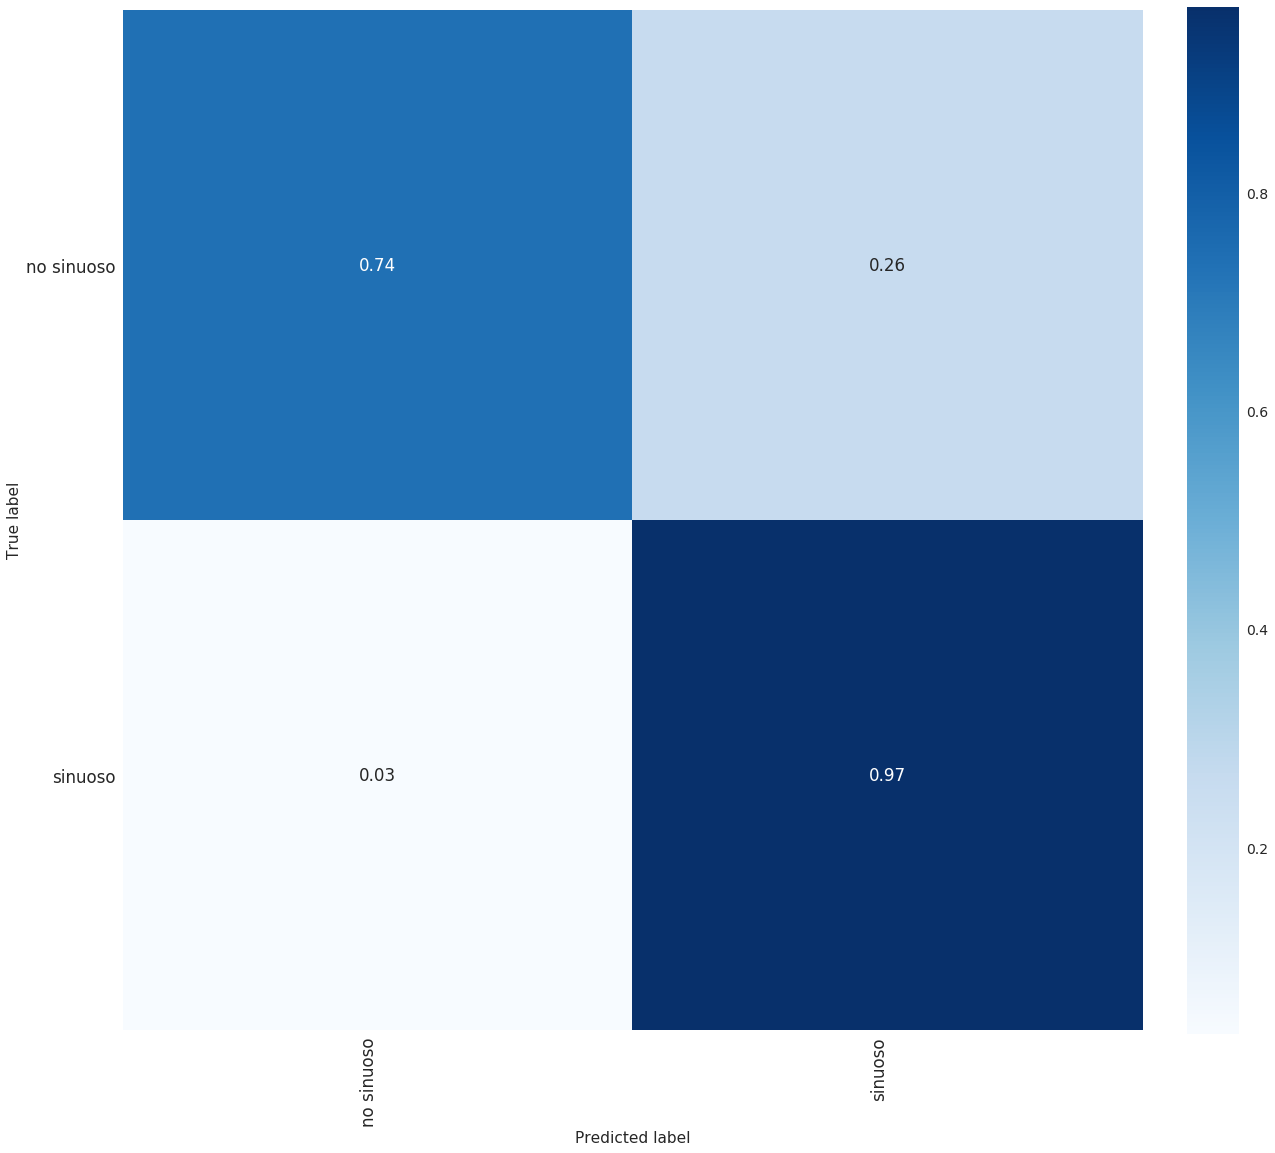

In [18]:
y_pred = np.array(pred_dict['pred_lab'])
y_true = np.repeat(np.array(pred_dict['true_lab']), y_pred.shape[1])
y_pred = y_pred.flatten()
weights = np.array(pred_dict['pred_prob']).flatten()

conf_mat = confusion_matrix(y_true, y_pred, labels=range(len(class_names)), sample_weight=weights)
normed_conf = conf_mat / np.sum(conf_mat, axis=1)[:, np.newaxis]

# plt_conf_matrix(conf_mat)
plt_conf_matrix(normed_conf, labels=class_names, name='Predicciones_Sinusoidad_weighted')

In [19]:
# save images that are wrong predicted in a list,
# to see if they share a pattern
wrong_predictions=[]
for i in range(len(pred_dict['true_lab'])):
    if pred_dict['pred_lab'][i][0]!=pred_dict['true_lab'][i]:
        wrong_predictions.append(pred_dict['filenames'][i])

In [20]:
# fold 5
wrong_predictions

['/srv/datos/ENVIO_ABRIL/No_tortuosos/No_tortuosos_spider/10240_SPIDER_n.jpg',
 '/srv/datos/ENVIO_ABRIL/No_tortuosos/No_tortuosos_spider/2622_SPIDER_n.jpg',
 '/srv/datos/ENVIO_ABRIL/No_tortuosos/No_tortuosos_spider/8631_SPIDER_n.jpg',
 '/srv/datos/ENVIO_ABRIL/No_tortuosos/No_tortuosos_spider/7122_SPIDER_n.jpg',
 '/srv/datos/ENVIO_ABRIL/No_tortuosos/No_tortuosos_45/4850_45_n.jpg',
 '/srv/datos/ENVIO_ABRIL/No_tortuosos/No_tortuosos_spider/1639_SPIDER_n.jpg',
 '/srv/datos/ENVIO_ABRIL/No_tortuosos/No_tortuosos_spider/6241_SPIDER_n.jpg']

In [10]:
# fold 4
wrong_predictions

['/srv/datos/ENVIO_ABRIL/Tortuosos/Tortuosos_spider/7844_SPIDER_s.jpg',
 '/srv/datos/ENVIO_ABRIL/Tortuosos/Tortuosos_spider/9378_SPIDER_s.jpg']

In [10]:
# fold 3
wrong_predictions

['/srv/datos/ENVIO_ABRIL/Tortuosos/Tortuosos_45/9475_45_s.jpg',
 '/srv/datos/ENVIO_ABRIL/No_tortuosos/No_tortuosos_spider/1647_SPIDER_n.jpg',
 '/srv/datos/ENVIO_ABRIL/Tortuosos/Tortuosos_45/2349_45_s.jpg',
 '/srv/datos/ENVIO_ABRIL/Tortuosos/Tortuosos_spider/10654_SPIDER_s.jpg',
 '/srv/datos/ENVIO_ABRIL/No_tortuosos/No_tortuosos_spider/P5433_SPIDER_n.jpg',
 '/srv/datos/ENVIO_ABRIL/Tortuosos/Tortuosos_45/1805_45_s.jpg',
 '/srv/datos/ENVIO_ABRIL/Tortuosos/Tortuosos_45/3814_45_s.jpg',
 '/srv/datos/ENVIO_ABRIL/Tortuosos/Tortuosos_45/8851_45_s.jpg',
 '/srv/datos/ENVIO_ABRIL/Tortuosos/Tortuosos_spider/10712_SPIDER_s.jpg']

In [12]:
# fold 2
wrong_predictions

['/srv/datos/ENVIO_ABRIL/Tortuosos/Tortuosos_45/7255_45_s.jpg',
 '/srv/datos/ENVIO_ABRIL/Tortuosos/Tortuosos_spider/7253_SPIDER_s.jpg',
 '/srv/datos/ENVIO_ABRIL/No_tortuosos/No_tortuosos_spider/8261_SPIDER_n.jpg',
 '/srv/datos/ENVIO_ABRIL/No_tortuosos/No_tortuosos_spider/8028_SPIDER_n.png',
 '/srv/datos/ENVIO_ABRIL/Tortuosos/Tortuosos_45/10435_45_s.jpg',
 '/srv/datos/ENVIO_ABRIL/No_tortuosos/No_tortuosos_spider/10548_SPIDER_n.jpg',
 '/srv/datos/ENVIO_ABRIL/No_tortuosos/No_tortuosos_spider/8305_SPIDER_n.png',
 '/srv/datos/ENVIO_ABRIL/Tortuosos/Tortuosos_spider/11337_SPIDER_s.jpg',
 '/srv/datos/ENVIO_ABRIL/Tortuosos/Tortuosos_spider/5567_SPIDER_s.jpg']

In [26]:
# fold 1
wrong_predictions

['/srv/datos/ENVIO_ABRIL/No_tortuosos/No_tortuosos_spider/5990_SPIDER_n.jpg',
 '/srv/datos/ENVIO_ABRIL/Tortuosos/Tortuosos_spider/8165_SPIDER_s.jpg',
 '/srv/datos/ENVIO_ABRIL/Tortuosos/Tortuosos_45/4161_45_s.jpg']